In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
import numpy as np


import os
import json
import pyarrow.parquet as pq
import pyarrow as pa
from datasets import Dataset, DatasetDict, concatenate_datasets
from datasets import Features, Value
from datasets import  load_dataset, DownloadConfig
from datasets import load_from_disk
import pandas as pd



from utils.data_loaders import BiBci2000MELR_filter, BiBci2000MELR
from models.bi_lstm import BiLSTMEncoder, ToyClassifier
from huggingface_hub import hf_hub_download
from huggingface_hub import snapshot_download
from PyEMD import CEEMDAN, EMD
import torch.nn.functional as F

In [2]:
# 超参数
BATCH_SIZE = 24
EPOCHS = 200
LEARNING_RATE = 0.0001
HIDDEN_SIZE = 50
NUM_LAYERS = 2
NUM_CLASSES = 1  # 二分类任务
INPUT_SIZE = 656  
SEQ_LENGTH = 64  


In [3]:
print(torch.cuda.is_available())  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

True
cuda


In [4]:
train_path = "D:\\EEG25_Data\\BCI2000_cls9\\sliced\\train"
test_path = "D:\\EEG25_Data\\BCI2000_cls9\\sliced\\test"

# 列出文件夹中的所有文件
train_files = os.listdir(train_path)
test_files = os.listdir(test_path)

# 筛选出所有的PT文件
train_files = [f for f in train_files if f.endswith('.pt')]
test_files = [f for f in test_files if f.endswith('.pt')]

# 初始化存储列表
train_data_list = []
train_label_list = []
test_data_list = []
test_label_list = []

# 处理测试集
index = 0
for pt_file in test_files:
    file_path = os.path.join(test_path, pt_file)
    try:
        data = torch.load(file_path)
        
        # 检查第二个维度长度
        if data.shape[1] < 640:
            print(f"跳过测试文件 {pt_file}，第二维度长度 {data.shape[1]} < 640")
            continue
            
        # 处理标签
        label = pt_file.split("_")[-1]
        label = label[3]  # 假设文件名格式为 XXX_clsX.pt
        test_label_list.append(int(label))  # 转换为整数
        
        # 处理数据
        data = data[:, :640]
        test_data_list.append(data)
        
    except Exception as e:
        print(f"加载测试文件 {pt_file} 失败: {str(e)}")
    
    index += 1
    print(f"测试集处理进度: {index/len(test_files):.2%}")

# 处理训练集
index = 0
for pt_file in train_files:
    file_path = os.path.join(train_path, pt_file)
    try:
        data = torch.load(file_path)
        
        # 检查第二个维度长度
        if data.shape[1] < 640:
            print(f"跳过训练文件 {pt_file}，第二维度长度 {data.shape[1]} < 640")
            continue
            
        # 处理标签
        label = pt_file.split("_")[-1]
        label = label[3]  # 假设文件名格式为 XXX_clsX.pt
        train_label_list.append(int(label))  # 转换为整数
        
        # 处理数据
        data = data[:, :640]
        train_data_list.append(data)
        
    except Exception as e:
        print(f"加载训练文件 {pt_file} 失败: {str(e)}")
    
    index += 1
    print(f"训练集处理进度: {index/len(train_files):.2%}")

# 最终统计信息
print("\n处理结果统计:")
print(f"有效测试样本数: {len(test_data_list)}/{len(test_files)}")
print(f"有效训练样本数: {len(train_data_list)}/{len(train_files)}")

测试集处理进度: 0.01%
测试集处理进度: 0.02%
测试集处理进度: 0.03%
测试集处理进度: 0.03%
测试集处理进度: 0.04%
测试集处理进度: 0.05%
测试集处理进度: 0.06%
测试集处理进度: 0.07%
测试集处理进度: 0.08%
测试集处理进度: 0.09%
测试集处理进度: 0.09%
测试集处理进度: 0.10%
测试集处理进度: 0.11%
测试集处理进度: 0.12%
测试集处理进度: 0.13%
测试集处理进度: 0.14%
测试集处理进度: 0.14%
测试集处理进度: 0.15%
测试集处理进度: 0.16%
测试集处理进度: 0.17%
测试集处理进度: 0.18%
测试集处理进度: 0.19%
测试集处理进度: 0.20%
测试集处理进度: 0.20%
测试集处理进度: 0.21%
测试集处理进度: 0.22%
测试集处理进度: 0.23%
测试集处理进度: 0.24%
测试集处理进度: 0.25%
测试集处理进度: 0.26%
测试集处理进度: 0.26%
测试集处理进度: 0.27%
测试集处理进度: 0.28%
测试集处理进度: 0.29%
测试集处理进度: 0.30%
测试集处理进度: 0.31%
测试集处理进度: 0.32%
测试集处理进度: 0.32%
测试集处理进度: 0.33%
测试集处理进度: 0.34%
测试集处理进度: 0.35%
测试集处理进度: 0.36%
测试集处理进度: 0.37%
测试集处理进度: 0.37%
测试集处理进度: 0.38%
测试集处理进度: 0.39%
测试集处理进度: 0.40%
测试集处理进度: 0.41%
测试集处理进度: 0.42%
测试集处理进度: 0.43%
测试集处理进度: 0.43%
测试集处理进度: 0.44%
测试集处理进度: 0.45%
测试集处理进度: 0.46%
测试集处理进度: 0.47%
测试集处理进度: 0.48%
测试集处理进度: 0.49%
测试集处理进度: 0.49%
测试集处理进度: 0.50%
测试集处理进度: 0.51%
测试集处理进度: 0.52%
测试集处理进度: 0.53%
测试集处理进度: 0.54%
测试集处理进度: 0.55%
测试集处理进度: 0.55%
测试集处理进度: 0.56%
测试集处理进度: 0

C:\Users\ChenYiqiao\AppData\Local\Temp\ipykernel_27264\132860326.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


测试集处理进度: 3.31%
测试集处理进度: 3.32%
测试集处理进度: 3.33%
测试集处理进度: 3.34%
测试集处理进度: 3.35%
测试集处理进度: 3.36%
测试集处理进度: 3.36%
测试集处理进度: 3.37%
测试集处理进度: 3.38%
测试集处理进度: 3.39%
测试集处理进度: 3.40%
测试集处理进度: 3.41%
测试集处理进度: 3.42%
测试集处理进度: 3.42%
测试集处理进度: 3.43%
测试集处理进度: 3.44%
测试集处理进度: 3.45%
测试集处理进度: 3.46%
测试集处理进度: 3.47%
测试集处理进度: 3.48%
测试集处理进度: 3.48%
测试集处理进度: 3.49%
测试集处理进度: 3.50%
测试集处理进度: 3.51%
测试集处理进度: 3.52%
测试集处理进度: 3.53%
测试集处理进度: 3.53%
测试集处理进度: 3.54%
测试集处理进度: 3.55%
测试集处理进度: 3.56%
测试集处理进度: 3.57%
测试集处理进度: 3.58%
测试集处理进度: 3.59%
测试集处理进度: 3.59%
测试集处理进度: 3.60%
测试集处理进度: 3.61%
测试集处理进度: 3.62%
测试集处理进度: 3.63%
测试集处理进度: 3.64%
测试集处理进度: 3.65%
测试集处理进度: 3.65%
测试集处理进度: 3.66%
测试集处理进度: 3.67%
测试集处理进度: 3.68%
测试集处理进度: 3.69%
测试集处理进度: 3.70%
测试集处理进度: 3.70%
测试集处理进度: 3.71%
测试集处理进度: 3.72%
测试集处理进度: 3.73%
测试集处理进度: 3.74%
测试集处理进度: 3.75%
测试集处理进度: 3.76%
测试集处理进度: 3.76%
测试集处理进度: 3.77%
测试集处理进度: 3.78%
测试集处理进度: 3.79%
测试集处理进度: 3.80%
测试集处理进度: 3.81%
测试集处理进度: 3.82%
测试集处理进度: 3.82%
测试集处理进度: 3.83%
测试集处理进度: 3.84%
测试集处理进度: 3.85%
测试集处理进度: 3.86%
测试集处理进度: 3.87%
测试集处理进度: 3

C:\Users\ChenYiqiao\AppData\Local\Temp\ipykernel_27264\132860326.py:50: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(file_path)


训练集处理进度: 0.00%
训练集处理进度: 0.01%
训练集处理进度: 0.01%
训练集处理进度: 0.01%
训练集处理进度: 0.02%
训练集处理进度: 0.02%
训练集处理进度: 0.03%
训练集处理进度: 0.03%
训练集处理进度: 0.03%
训练集处理进度: 0.04%
训练集处理进度: 0.04%
训练集处理进度: 0.04%
训练集处理进度: 0.05%
训练集处理进度: 0.05%
训练集处理进度: 0.05%
训练集处理进度: 0.06%
训练集处理进度: 0.06%
训练集处理进度: 0.07%
训练集处理进度: 0.07%
训练集处理进度: 0.07%
训练集处理进度: 0.08%
训练集处理进度: 0.08%
训练集处理进度: 0.08%
训练集处理进度: 0.09%
训练集处理进度: 0.09%
训练集处理进度: 0.09%
训练集处理进度: 0.10%
训练集处理进度: 0.10%
训练集处理进度: 0.11%
训练集处理进度: 0.11%
训练集处理进度: 0.11%
训练集处理进度: 0.12%
训练集处理进度: 0.12%
训练集处理进度: 0.12%
训练集处理进度: 0.13%
训练集处理进度: 0.13%
训练集处理进度: 0.14%
训练集处理进度: 0.14%
训练集处理进度: 0.14%
训练集处理进度: 0.15%
训练集处理进度: 0.15%
训练集处理进度: 0.15%
训练集处理进度: 0.16%
训练集处理进度: 0.16%
训练集处理进度: 0.16%
训练集处理进度: 0.17%
训练集处理进度: 0.17%
训练集处理进度: 0.18%
训练集处理进度: 0.18%
训练集处理进度: 0.18%
训练集处理进度: 0.19%
训练集处理进度: 0.19%
训练集处理进度: 0.19%
训练集处理进度: 0.20%
训练集处理进度: 0.20%
训练集处理进度: 0.20%
训练集处理进度: 0.21%
训练集处理进度: 0.21%
训练集处理进度: 0.22%
训练集处理进度: 0.22%
训练集处理进度: 0.22%
训练集处理进度: 0.23%
训练集处理进度: 0.23%
训练集处理进度: 0.23%
训练集处理进度: 0.24%
训练集处理进度: 0.24%
训练集处理进度: 0

In [5]:
print(type(train_data_list))
print(len(test_data_list))
print(test_data_list[0].shape)

<class 'list'>
11625
torch.Size([64, 640])


In [6]:
class dataset(torch.utils.data.Dataset):
    def __init__(self, datas, labels):
        self.datas = datas
        self.labels = labels

    def __getitem__(self, index):
        eeg = self.datas[index]
        label = self.labels[index]

        return eeg, torch.tensor(label, dtype=torch.long)
    
    def __len__(self):
        return len(self.datas)
        
train_set = dataset(train_data_list, train_label_list)
test_set = dataset(test_data_list, test_label_list)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_loader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [63]:
simple_batch = train_set[1][0]
simple_batch = simple_batch[None, :]

class SELayer1D(nn.Module):
    def __init__(self, channels, reduction_ratio=8):
        super().__init__()
        assert channels % reduction_ratio == 0, f"通道数{channels}必须能被reduction_ratio{reduction_ratio}整除"
        
        self.avg_pool = nn.AdaptiveAvgPool1d(1)  # 针对一维特征的全局池化
        self.fc = nn.Sequential(
            nn.Linear(channels, channels // reduction_ratio, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channels // reduction_ratio, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, l = x.size()
        
        # Squeeze
        y = self.avg_pool(x)
        y = y.view(b, c)
        
        # Excitation
        y = self.fc(y)
        y = y.view(b, c, 1)
        
        # Scale
        return x * y.expand_as(x)

class CMO_CNN(nn.Module):
    def __init__(self):
        super(CMO_CNN, self).__init__()

        #branch1
        self.c1 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=20, stride=2, padding=0)
        self.bn1 = nn.BatchNorm1d(num_features=32)
        self.e1 = nn.ELU()
        self.se1 = SELayer1D(32)
        self.mp1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.c2 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=9, stride=2, padding=0)
        self.bn2 = nn.BatchNorm1d(num_features=32)
        self.e2 = nn.ELU()
        self.se2 = SELayer1D(32)
        self.mp2 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.c3 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.bn3 = nn.BatchNorm1d(num_features=32)
        self.e3 = nn.ELU()
        self.c4 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=2)
        self.bn4 = nn.BatchNorm1d(num_features=32)
        self.e4 = nn.ELU()
        self.se3 = SELayer1D(32)
        self.mp3 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.c5 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm1d(num_features=32)
        self.e5 = nn.ELU()
        self.c6 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn6 = nn.BatchNorm1d(num_features=32)
        self.e6 = nn.ELU()
        self.se4 = SELayer1D(32)
        self.mp4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.d1 = nn.Dropout(p=0.5)
        self.f1 = nn.Flatten()

        #branch2
        self.c7 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=13, stride=2, padding=0)
        self.bn7 = nn.BatchNorm1d(num_features=32)
        self.e7 = nn.ELU()
        self.se5 = SELayer1D(32)
        self.c8 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=7, stride=2, padding=0)
        self.bn8 = nn.BatchNorm1d(num_features=32)
        self.e8 = nn.ELU()
        self.se6 = SELayer1D(32)
        self.mp5 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.c9 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.bn9 = nn.BatchNorm1d(num_features=32)
        self.e9 = nn.ELU()
        self.se7 = SELayer1D(32)
        self.mp6 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.c10 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn10 = nn.BatchNorm1d(num_features=32)
        self.e10 = nn.ELU()
        self.c11 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn11 = nn.BatchNorm1d(num_features=32)
        self.e11 = nn.ELU()
        self.se8 = SELayer1D(32)
        self.mp7 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.d2 = nn.Dropout(p=0.5)
        self.f2 = nn.Flatten()

        #branch3
        self.c12 = nn.Conv1d(in_channels=64, out_channels=32, kernel_size=15, stride=2, padding=0)
        self.bn12 = nn.BatchNorm1d(num_features=32)
        self.e12 = nn.ELU()
        self.se9 = SELayer1D(32)
        self.mp8 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.c13 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=10, stride=2, padding=0)
        self.bn13 = nn.BatchNorm1d(num_features=32)
        self.e13 = nn.ELU()
        self.se10 = SELayer1D(32)
        self.c14 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=5, stride=1, padding=0)
        self.bn14 = nn.BatchNorm1d(num_features=32)
        self.e14 = nn.ELU()
        self.se11 = SELayer1D(32)
        self.mp9 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.c15 = nn.Conv1d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding=0)
        self.bn15 = nn.BatchNorm1d(num_features=32)
        self.e15 = nn.ELU()
        self.se12 = SELayer1D(32)
        self.mp10 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.d3 = nn.Dropout(p=0.5)
        self.f3 = nn.Flatten()


    def forward(self, x):
        #branch1
        x1 = x.clone()
        x1 = self.c1(x1)
        x1 = self.bn1(x1)
        x1 = self.e1(x1)
        x1 = self.se1(x1)
        x1 = self.mp1(x1)
        x1 = self.c2(x1)
        x1 = self.bn2(x1)
        x1 = self.e2(x1)
        x1 = self.se2(x1)
        x1 = self.mp2(x1)
        x1_r = x1.clone()
        x1 = self.c3(x1)
        x1 = self.bn3(x1)
        x1 = self.e3(x1)
        x1 = self.c4(x1)
        x1 = self.bn4(x1)
        x1 = self.e4(x1)
        x1 = self.se3(x1)
        x1 += x1_r
        x1 = self.mp3(x1)
        x1_r = x1.clone()
        x1 = self.c5(x1)
        x1 = self.bn5(x1)
        x1 = self.e5(x1)
        x1 = self.c6(x1)
        x1 = self.bn6(x1)
        x1 = self.e6(x1)
        x1 = self.se4(x1)
        x1 += x1_r
        x1 = self.mp4(x1)
        x1 = self.d1(x1)
        x1 = self.f1(x1)

        #branch2
        x2 = x.clone()
        x2 = self.c7(x2)
        x2 = self.bn7(x2)
        x2 = self.e7(x2)
        x2 = self.se5(x2)
        x2 = self.c8(x2)
        x2 = self.bn8(x2)
        x2 = self.e8(x2)
        x2 = self.se6(x2)
        x2 = self.mp5(x2)
        x2 = self.c9(x2)
        x2 = self.bn9(x2)
        x2 = self.e9(x2)
        x2 = self.se7(x2)
        x2 = self.mp6(x2)
        x2_r = x2.clone()
        x2 = self.c10(x2)
        x2 = self.bn10(x2)
        x2 = self.e10(x2)
        x2 = self.c11(x2)
        x2 = self.bn11(x2)
        x2 = self.e11(x2)
        x2 = self.se8(x2)
        x2 += x2_r
        x2 = self.mp7(x2)
        x2 = self.d1(x2)
        x2 = self.f1(x2)

        #branch3
        x3 = x.clone()
        x3 = self.c12(x3)
        x3 = self.bn12(x3)
        x3 = self.e12(x3)
        x3 = self.se9(x3)
        x3 = self.mp8(x3)
        x3 = self.c13(x3)
        x3 = self.bn13(x3)
        x3 = self.e13(x3)
        x3 = self.se10(x3)
        x3 = self.c14(x3)
        x3 = self.bn14(x3)
        x3 = self.e14(x3)
        x3 = self.se11(x3)
        x3 = self.mp9(x3)
        x3 = self.bn15(x3)
        x3 = self.e15(x3)
        x3 = self.se12(x3)
        x3 = self.mp10(x3)
        x3 = self.d1(x3)
        x3 = self.f1(x3)

        feature = torch.cat((x1, x2, x3), axis=1)

        return feature

class ClassificationHead(nn.Module):
    def __init__(self, 
                 input_dim=512, 
                 num_classes=8,
                 hidden_dims=[512, 256, 128],      # 隐藏层维度设置
                 dropout_prob=0.3,       # Dropout概率
                 use_batchnorm=False):   # 是否使用批归一化
        super().__init__()
        
        layers = []
        current_dim = input_dim
        
        # 动态构建隐藏层
        for h_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, h_dim))
            
            if use_batchnorm:
                layers.append(nn.BatchNorm1d(h_dim))
                
            layers.append(nn.ReLU(inplace=True))
            
            if dropout_prob > 0:
                layers.append(nn.Dropout(p=dropout_prob))
            
            current_dim = h_dim
        
        # 最终分类层
        layers.append(nn.Linear(current_dim, num_classes))
        
        self.head = nn.Sequential(*layers)
        
        # 权重初始化
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.head(x)
#初始化模型
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.backbone = CMO_CNN()
        self.classifier = ClassificationHead(input_dim=1408, num_classes=9)

    def forward(self, x):
        features = self.backbone(x)
        logits = self.classifier(features)
        return logits
model = Model().to(device)

#-----------------------------------------------------------------------------------------------------------------------------------------------------
#loss函数类加权
class_counts = np.array([13705, 1711, 1724, 1696, 1715, 1709, 1694, 1716, 1710])
median = np.median(class_counts)
weights = median / class_counts
weights = torch.tensor(weights, dtype=torch.float32)
weights = torch.softmax(weights, axis=0)
print("各类别权重:")
for i, w in enumerate(weights.numpy()):
    print(f"cls{i}: {w:.4f}")

# 数据加载器应使用加权采样
from torch.utils.data import WeightedRandomSampler

sample_weights = [weights[target] for (data, target) in train_set]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
train_loader = DataLoader(train_set, batch_size=64, sampler=sampler)

def focal_loss(input_values, gamma):
    """Computes the focal loss"""
    p = torch.exp(-input_values)   #目标类概率
    loss = (1 - p.detach()) ** gamma * input_values
    return loss.mean()


class FocalLoss(nn.Module):
    def __init__(self, weight=None, gamma=0.):
        super(FocalLoss, self).__init__()
        assert gamma >= 0
        self.gamma = gamma
        self.weight = weight

    def forward(self, input, target):
        return focal_loss(F.cross_entropy(input, target, reduction='none', weight=self.weight), self.gamma)

"""class DynamicFocalLoss(nn.Module):
    def __init__(self, class_counts, gamma=2.0, temp=0.5, smooth=1e-6):
        super().__init__()
        self.gamma = gamma
        self.temp = temp
        self.smooth = smooth
        
        # 初始化基权重（基于全局分布）
        self.base_weights = self._compute_base_weights(class_counts)
        
    def _compute_base_weights(self, class_counts):
        counts = torch.tensor(class_counts) if not isinstance(class_counts, torch.Tensor) else class_counts
        return 1.0 / torch.sqrt(counts.float() + self.smooth)
    
    def forward(self, inputs, targets):
        # 动态计算当前batch的类别分布
        batch_counts = torch.bincount(targets, minlength=len(self.base_weights))
        batch_weights = 1.0 / (batch_counts.float() + self.smooth)
        
        # 混合基权重与动态权重
        dynamic_weights = self.temp * self.base_weights.to(inputs.device) + (1 - self.temp) * batch_weights.to(inputs.device)
        
        # 权重归一化（保持均值1）
        dynamic_weights = dynamic_weights / dynamic_weights.mean()
        
        # 计算带权重的交叉熵损失
        ce_loss = F.cross_entropy(
            inputs, targets,
            weight=dynamic_weights,
            reduction='none'  # 保持每个样本的损失值
        )
        
        # 计算Focal Loss
        p = torch.exp(-ce_loss.detach())  # 目标类概率
        focal_loss = (1 - p) ** self.gamma * ce_loss
        
        return focal_loss.mean()"""

#类加权
#loss函数类加权
class_counts = np.array([13705, 1711, 1724, 1696, 1715, 1709, 1694, 1716, 1710])
median = np.median(class_counts)
weights = median / class_counts
weights = torch.tensor(weights, dtype=torch.float32)
weights = torch.softmax(weights, axis=0)

# 交叉熵损失
ce_loss = nn.CrossEntropyLoss()

#=====================================================================================================================================================
# 阶段1：正常训练全部参数
#=====================================================================================================================================================
criterion_t1= torch.nn.CrossEntropyLoss()
optimizer_t1 = optim.Adam(list(model.parameters()), lr=LEARNING_RATE)
#=====================================================================================================================================================
# 阶段2：冻结backbone，平衡采样
#=====================================================================================================================================================
#微噪声
criterion_t2 = FocalLoss(weight=weights.to(device), gamma=1).to(device)
optimizer_t2 = optim.Adam(list(model.classifier.parameters()), lr=LEARNING_RATE)

各类别权重:
cls0: 0.0495
cls1: 0.1187
cls2: 0.1178
cls3: 0.1198
cls4: 0.1184
cls5: 0.1188
cls6: 0.1199
cls7: 0.1184
cls8: 0.1188


In [72]:
print("==== 第一阶段训练（原始数据）====")
for epoch in range(40):
    model.train()
    total_loss = 0
    total_ce = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer_t1.zero_grad()  # 清空梯度
        outputs = model(X_batch)
        loss = criterion_t1(outputs, y_batch)  # 计算损失
        loss.backward()  # 反向传播
        optimizer_t1.step()  # 更新参数

        total_loss += loss.item()

        #观测CE值
        loss_ce = ce_loss(outputs, y_batch)
        total_ce += loss_ce.item()

    print(f"Epoch [{epoch+1}] CELoss: {total_loss / len(train_loader):.6f} CELoss: {total_ce / len(train_loader):.6f}")

print("\n==== 第二阶段训练（平衡数据）====")
for param in model.backbone.parameters():
    param.requires_grad = False
#加权采样
sample_weights = [weights[target] for (data, target) in train_set]
sampler = WeightedRandomSampler(sample_weights, len(sample_weights))
train_loader = DataLoader(train_set, batch_size=48, sampler=sampler)
for epoch in range(200):
    model.train()
    total_loss = 0
    total_ce = 0

    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer_t2.zero_grad()  # 清空梯度
        outputs = model(X_batch)
        loss = criterion_t2(outputs, y_batch)  # 计算损失
        loss.backward()  # 反向传播
        optimizer_t2.step()  # 更新参数

        total_loss += loss.item()

        #观测CE值
        loss_ce = ce_loss(outputs, y_batch)
        total_ce += loss_ce.item()

    print(f"Epoch [{epoch+1}] FLLoss: {total_loss / len(train_loader):.6f} CELoss: {total_ce / len(train_loader):.6f}")

==== 第一阶段训练（原始数据）====
Epoch [1] CELoss: 0.544688 CELoss: 0.544688
Epoch [2] CELoss: 0.519429 CELoss: 0.519429
Epoch [3] CELoss: 0.514725 CELoss: 0.514725
Epoch [4] CELoss: 0.513080 CELoss: 0.513080
Epoch [5] CELoss: 0.502091 CELoss: 0.502091
Epoch [6] CELoss: 0.515638 CELoss: 0.515638
Epoch [7] CELoss: 0.507640 CELoss: 0.507640
Epoch [8] CELoss: 0.511330 CELoss: 0.511330
Epoch [9] CELoss: 0.505509 CELoss: 0.505509
Epoch [10] CELoss: 0.499053 CELoss: 0.499053
Epoch [11] CELoss: 0.492869 CELoss: 0.492869
Epoch [12] CELoss: 0.480356 CELoss: 0.480356
Epoch [13] CELoss: 0.491007 CELoss: 0.491007
Epoch [14] CELoss: 0.482958 CELoss: 0.482958
Epoch [15] CELoss: 0.479543 CELoss: 0.479543
Epoch [16] CELoss: 0.479538 CELoss: 0.479538
Epoch [17] CELoss: 0.485833 CELoss: 0.485833
Epoch [18] CELoss: 0.479879 CELoss: 0.479879
Epoch [19] CELoss: 0.455053 CELoss: 0.455053
Epoch [20] CELoss: 0.466253 CELoss: 0.466253
Epoch [21] CELoss: 0.462462 CELoss: 0.462462
Epoch [22] CELoss: 0.459586 CELoss: 0.4595

In [73]:
#保存模型
torch.save(model.state_dict, "parameter\\FL_COM_CNN_cls9_b40c200")

In [ ]:
import torch
from torch.utils.data import DataLoader
import numpy as np
 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') 
model.to(device) 
model.eval() 

#推理之前对模型分类器权重做归一化
model.classifier.head[-1].weight.data = F.normalize(model.classifier.head[-1].weight.data, p=2, dim=1)
 
# 存储真实标签和预测结果 
all_labels = [] 
all_logits = [] 
 
# 假设dataset是PyTorch Dataset对象 
dataloader = DataLoader(test_set, batch_size=32, shuffle=False)

with torch.no_grad():
    for inputs, labels in dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        
        all_logits.append(outputs.cpu())
        all_labels.append(labels.cpu())

# 合并结果
y_true = torch.cat(all_labels).numpy()          # 形状 [n_samples]
logits = torch.cat(all_logits).numpy()          # 形状 [n_samples, 9]
y_pred = logits.argmax(axis=1)                  # 预测类别 [n_samples]
y_probs = torch.softmax(torch.tensor(logits), dim=1).numpy()  # 概率 [n_samples, 9]

print((y_pred==0).any())

True


In [79]:
from sklearn.metrics import (
    accuracy_score, confusion_matrix,
    classification_report, roc_auc_score
)

# 基础指标
print(f"FL 准确率: {accuracy_score(y_true, y_pred):.4f}")
print(f"FL 宏平均ROC AUC: {roc_auc_score(y_true, y_probs, multi_class='ovr'):.4f}")

# 分类报告（显示每个类别的精确率/召回率/F1）
print("\nFL 分类报告:")
print(classification_report(y_true, y_pred, target_names=[f"类{i}" for i in range(9)]))

FL 准确率: 0.5474
FL 宏平均ROC AUC: 0.8524

FL 分类报告:
              precision    recall  f1-score   support

          类0       0.91      0.70      0.79      5759
          类1       0.23      0.33      0.27       734
          类2       0.37      0.40      0.38       739
          类3       0.35      0.42      0.38       728
          类4       0.41      0.45      0.43       736
          类5       0.27      0.36      0.31       733
          类6       0.34      0.38      0.36       727
          类7       0.31      0.43      0.36       736
          类8       0.35      0.44      0.39       733

    accuracy                           0.55     11625
   macro avg       0.39      0.43      0.41     11625
weighted avg       0.62      0.55      0.57     11625



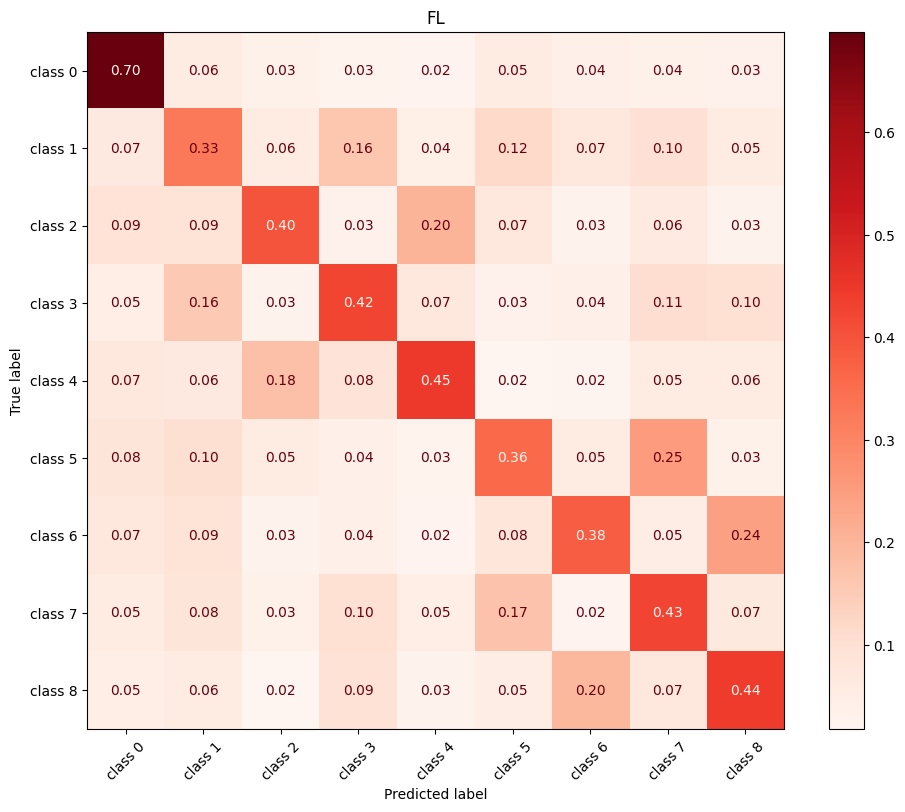

In [80]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


# 混淆矩阵
cm = confusion_matrix(y_true, y_pred, normalize="true")
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=[f"class {i}" for i in range(9)]
)
fig, ax = plt.subplots(figsize=(10, 8))
disp.plot(ax=ax, cmap='Reds', values_format='.2f')
plt.xticks(rotation=45)
plt.tight_layout()
plt.title("FL")
#plt.savefig('confusion_matrix.png', dpi=300)
plt.show()

In [81]:
# 计算每个类别的ROC AUC（One-vs-Rest）
from sklearn.preprocessing import label_binarize

# 将标签转换为二值形式
y_true_bin = label_binarize(y_true, classes=range(8))

# 计算每个类别的AUC
for i in range(8):
    auc = roc_auc_score(y_true_bin[:, i], y_probs[:, i])
    print(f"类{i}的ROC AUC: {auc:.4f}")

类0的ROC AUC: 0.9291
类1的ROC AUC: 0.7765
类2的ROC AUC: 0.8581
类3的ROC AUC: 0.8620
类4的ROC AUC: 0.8735
类5的ROC AUC: 0.8175
类6的ROC AUC: 0.8509
类7的ROC AUC: 0.8406


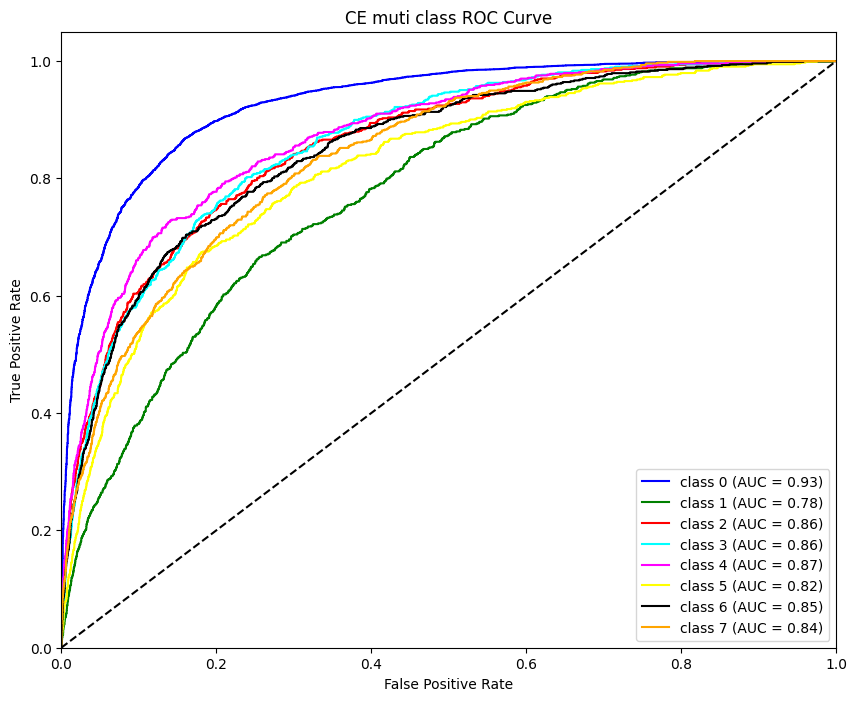

In [82]:
from sklearn.metrics import roc_curve, auc

plt.figure(figsize=(10, 8))
colors = ['blue', 'green', 'red', 'cyan', 'magenta', 'yellow', 'black', 'orange']

# 为每个类别绘制ROC曲线
for i in range(8):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=colors[i],
             label=f'class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CE muti class ROC Curve')
plt.legend(loc="lower right")
plt.show()

In [71]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, cohen_kappa_score, matthews_corrcoef

def calculate_imbalanced_metrics(y_true, y_pred, y_probs):
    """
    计算类不平衡分类任务的综合评估指标
    
    参数：
        y_true: 真实标签 [n_samples]
        y_pred: 预测标签 [n_samples]
        y_probs: 各类别概率 [n_samples, 9]
    
    返回：
        包含各项指标的字典
    """
    metrics = {}
    
    # 基础分类报告（包含precision/recall/f1的macro和weighted平均）
    report = classification_report(
        y_true, y_pred,
        target_names=[f'cls{i}' for i in range(9)],
        output_dict=True
    )
    
    # 将分类报告整合到指标字典
    metrics.update({
        'macro_precision': report['macro avg']['precision'],
        'macro_recall': report['macro avg']['recall'],
        'macro_f1': report['macro avg']['f1-score'],
        'weighted_precision': report['weighted avg']['precision'],
        'weighted_recall': report['weighted avg']['recall'],
        'weighted_f1': report['weighted avg']['f1-score'],
        'accuracy': report['accuracy']
    })
    
    # 混淆矩阵相关指标
    cm = confusion_matrix(y_true, y_pred)
    metrics['confusion_matrix'] = cm
    
    # 平衡准确率（各类别召回率的平均）
    metrics['balanced_accuracy'] = np.mean([cm[i,i]/cm[i,:].sum() for i in range(9)])
    
    # 多类别AUC（One-vs-Rest方法）
    try:
        metrics['roc_auc_ovr_macro'] = roc_auc_score(
            y_true, y_probs, 
            multi_class='ovr', 
            average='macro'
        )
        metrics['roc_auc_ovr_weighted'] = roc_auc_score(
            y_true, y_probs,
            multi_class='ovr',
            average='weighted'
        )
    except Exception as e:
        print(f"AUC计算异常: {str(e)}")
        metrics.update({'roc_auc_ovr_macro': None, 'roc_auc_ovr_weighted': None})
    
    # Cohen's Kappa
    metrics['cohens_kappa'] = cohen_kappa_score(y_true, y_pred)
    
    # 马修斯相关系数（MCC）
    metrics['mcc'] = matthews_corrcoef(y_true, y_pred)
    
    # 类别分布统计
    class_distribution = np.bincount(y_true, minlength=9)
    metrics.update({
        'class_distribution': class_distribution,
        'imbalance_ratio': class_distribution.max() / class_distribution.min()
    })
    
    return metrics

# 使用示例
metrics = calculate_imbalanced_metrics(y_true, y_pred, y_probs)

# 打印关键指标
print(f"【关键指标】")
print(f"宏平均F1: {metrics['macro_f1']:.4f}")
print(f"加权F1: {metrics['weighted_f1']:.4f}")
print(f"平衡准确率: {metrics['balanced_accuracy']:.4f}")
print(f"AUC-OVR宏平均: {metrics['roc_auc_ovr_macro']:.4f}")
print(f"马修斯相关系数: {metrics['mcc']:.4f}")
print(f"类别不平衡比: {metrics['imbalance_ratio']:.1f}:1")

# 输出混淆矩阵（可视化建议）
print("\n【混淆矩阵样例】")
print(metrics['confusion_matrix'])  # 显示前3x3部分

【关键指标】
宏平均F1: 0.4096
加权F1: 0.5710
平衡准确率: 0.4394
AUC-OVR宏平均: 0.8558
马修斯相关系数: 0.4199
类别不平衡比: 7.9:1

【混淆矩阵样例】
[[3907  323  220  210  136  304  265  188  206]
 [  49  228   33  134   42   80   65   54   49]
 [  57   68  280   28  158   62   23   39   24]
 [  34   88   20  334   59   18   31   74   70]
 [  33   50  125   75  344   12   18   33   46]
 [  47   74   43   39   19  316   48  120   27]
 [  38   64   17   39   20   52  295   30  172]
 [  27   61   28   80   38  154   24  284   40]
 [  29   50    8   72   28   28  160   37  321]]
